In [ ]:
!pip install mesa

In [2]:
#La clase Model para manejar los agentes y la clase Agent para un definir un agente.
from mesa import Agent, Model

# Debido a que necesitamos varios agentes por celda, elegimos ''MultiGrid''.
from mesa.space import MultiGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

# Con ''DataCollector'', vamos a recuperar información del modelo.
from mesa.datacollection import DataCollector

# matplotlib lo vamos a utilizar para realizar una ''animación'' de mi modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

# Definimos otros paquete que vamos a usar para medir el tiempo de ejecución del modelo
import time
import datetime

MAXVAL = 10000

In [3]:
class RobotVacuumCleanerAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.options = np.array([ [-1, -1], [-1,  0], [-1, +1],
                                  [ 0, -1],           [ 0, +1],
                                  [+1, -1], [+1,  0], [+1, +1] ])
        self.moves = 0;
        
    def can_move(self, x, y):
        return (x >= 0 and x < self.model.grid.width and 
                y >= 0 and y < self.model.grid.height)
        
    def step(self):
        if self.model.floor[self.pos[0]][self.pos[1]] == 1:
            self.model.floor[self.pos[0]][self.pos[1]] = 0
        else:
            i = int( np.random.rand() * MAXVAL ) % len(self.options)
            x = self.pos[0] + self.options[i][0]
            y = self.pos[1] + self.options[i][1]
            if self.can_move(x, y):
                self.model.grid.move_agent(self, (x, y))
                self.moves += 1
                
def get_grid(model):
    """ Esta función nos permite obtener el estado de los diferentes agentes.
        *param* model : Modelo del que obtendrá la información. 
        *return* una matriz con la información del estado de cada uno de los agentes."""
    grid = np.zeros( (model.grid.width, model.grid.height) )
    for x in range (model.grid.width):
        for y in range (model.grid.height):
            if model.grid.is_cell_empty( (x, y) ) :
                grid[x][y] = model.floor[x][y] * 2
            else:
                grid[x][y] = 1
    #print (grid)
    return grid
    
class RobotVacuumCleanerModel(Model):
    def __init__(self, width, height, num_agents, dirty_cells_percentage = 0.5):
        self.num_agents = num_agents
        self.dirty_cells_percentage = dirty_cells_percentage
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.floor = np.zeros( (width, height) )
        
        # Create agents
        for i in range(self.num_agents):
            a = RobotVacuumCleanerAgent(i, self)
            self.grid.place_agent(a, (0, 0))
            self.schedule.add(a)
            
        # Initializate the ''dirty'' cells
        amount = int((width * height) * dirty_cells_percentage)
        for i in range(amount):
            finished = False
            while not finished:
                x = int(np.random.rand() * MAXVAL) % width
                y = int(np.random.rand() * MAXVAL) % height
                if self.floor[x][y] == 0:
                    self.floor[x][y] = 1
                    finished = True
        #print(self.floor)
                    
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})
        
    def is_all_clean(self):
        return np.all(self.floor == 0)

    def cleaned_percentage(self):
      return (1 - (self.floor.sum()/(self.floor.shape[0]*self.floor.shape[1])))*100

    def show_moves(self):
      for agent in self.schedule.agents:
        print("Agente " + str(agent.unique_id) + ": " + str(agent.moves))
            
    def step(self):
        """ Ejecuta un paso de la simulación."""
        self.datacollector.collect(self)
        self.schedule.step()

In [62]:
# Definimos el tamaño del Grid
GRID_SIZE = 20

# Definimos el número máximo de generaciones a correr
MAX_GENERATIONS = 200

AGENTS = 20

# Registramos el tiempo de inicio y ejecutamos la simulación
start_time = time.time()
model = RobotVacuumCleanerModel(GRID_SIZE, GRID_SIZE, AGENTS, 0.7)
steps = 0

while steps < MAX_GENERATIONS and not model.is_all_clean():
    model.step()
    steps += 1

steps_clean = steps
cleaned_percentage = model.cleaned_percentage()

while not model.is_all_clean():
    model.step()
    steps_clean += 1
    

In [63]:
# Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información.
all_grid = model.datacollector.get_model_vars_dataframe()

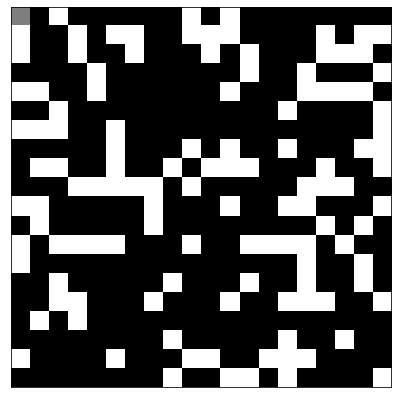

In [64]:
# Graficamos la información usando `matplotlib`
# %%capture

fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=MAX_GENERATIONS)

In [65]:
anim

In [66]:
print("Numero de pasos realizados por " + str(AGENTS) + " agentes: " + str(steps))
print("Porcentaje de celdas limpias: " + str(cleaned_percentage) + "%")
print("Numero de pasos necesarios para para que todas las celdas estén limpias: " + str(steps_clean))
print("\nMovimientos realizados por cada agente para para que todas las celdas estén limpias: ")

model.show_moves()

Numero de pasos realizados por 20 agentes: 200
Porcentaje de celdas limpias: 90.5%
Numero de pasos necesarios para para que todas las celdas estén limpias: 640

Movimientos realizados por cada agente para para que todas las celdas estén limpias: 
Agente 0: 565
Agente 1: 551
Agente 2: 574
Agente 3: 592
Agente 4: 548
Agente 5: 596
Agente 6: 572
Agente 7: 583
Agente 8: 563
Agente 9: 564
Agente 10: 573
Agente 11: 572
Agente 12: 538
Agente 13: 564
Agente 14: 598
Agente 15: 578
Agente 16: 590
Agente 17: 569
Agente 18: 558
Agente 19: 593
